#### STA 141C - Big Data & High Performance Statistical Computing Spring 2022

#### Homework # 2

##### JONGWOOk CHOE

##### May 6, 2022

In [18]:
# library
import numpy as np
import pandas as pd
import scipy.linalg as sl
from sklearn.linear_model import LinearRegression
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pylab as plt
import scipy.sparse as sparse
import time
import math


1. Read in the ‘longley.dat’ with the response (number of people employed) in the first column and six explanatory variables in the other columns (GNP implicit price deflator, Gross National Product, number of unemployed, number of people in the armed forces, “noninstitutionalized” population % 14 years of age, year). Include an intercept in you model.

In [19]:
# Reading data using pandas
longley = pd.read_csv("longley.dat", header=None, delim_whitespace=True)

In [20]:
# Renaming the columns 
longley.rename(columns={0:"number of people employed", 1:"GNP implicit price deflator", 2: "Gross National Product", 3:"number of unemployed",
4: "number of people in the armed forces", 5: "noninstitutionalized population", 6: "year"}, inplace=True)

longley.head()

,number of people employed,GNP implicit price deflator,Gross National Product,number of unemployed,number of people in the armed forces,noninstitutionalized population,year
0,60323,83.0,234289,2356,1590,107608,1947
1,61122,88.5,259426,2325,1456,108632,1948
2,60171,88.2,258054,3682,1616,109773,1949
3,61187,89.5,284599,3351,1650,110929,1950
4,63221,96.2,328975,2099,3099,112075,1951


In [21]:
# Linear Regression module
lm = LinearRegression()

# Y
Y = longley.iloc[:,0:1]

# X
X = longley.iloc[:,1:]

# fit data
model = lm.fit(X, Y)


print(model.coef_)
print(model.intercept_)


[[ 1.50618723e+01 -3.58191793e-02 -2.02022980e+00 -1.03322687e+00
  -5.11041057e-02  1.82915146e+03]]
[-3482258.63459582]


2. Assuming linear model $y \sim N(X\beta,\sigma^2I),$ compute 

1) Regression coefficients $\hat{\beta} = (X^′X)^{−1}X^′y,$ 
2) Standard errors of $\hat{\beta} = \sigma^2\text{diag}((X^′X)^{−1}),$ and 
3) Variance estimate $\hat{\sigma}^2 = (Y -X^′\hat{\beta})′(Y -X^′\hat{\beta})$ 

using following methods: GE/LU decomposition, Cholesky decomposition, and QR decomposition, and compare the computation speed for each method. Please compute them directly using numerical linear algebra functions; you can use the “black-box” function (e.g., lm() in R or sklearn.linear model.LinearRegression in python) only to check your results. (Hint: chol2inv() function in R computes the inverse of a matrix from its Cholesky factor. In python, you may try cho solve())

##### GE/LU  decomposition

In [22]:
# make array of A and b from the data
A = longley.iloc[:,1:]
b = longley.iloc[:,0:1]

A = np.array(A)

# add column of one for intercept
ncol = np.array(np.repeat(1, len(A)))
ncol = ncol.reshape(-1,1)
# ncol.shape

An = np.append(A, ncol, axis=1)

An = An[:, [6,0,1,2,3,4,5]]



print(np.array_str(An, precision=5, suppress_small=True))

[[     1.      83.  234289.    2356.    1590.  107608.    1947. ]
 [     1.      88.5 259426.    2325.    1456.  108632.    1948. ]
 [     1.      88.2 258054.    3682.    1616.  109773.    1949. ]
 [     1.      89.5 284599.    3351.    1650.  110929.    1950. ]
 [     1.      96.2 328975.    2099.    3099.  112075.    1951. ]
 [     1.      98.1 346999.    1932.    3594.  113270.    1952. ]
 [     1.      99.  365385.    1870.    3547.  115094.    1953. ]
 [     1.     100.  363112.    3578.    3350.  116219.    1954. ]
 [     1.     101.2 397469.    2904.    3048.  117388.    1955. ]
 [     1.     104.6 419180.    2822.    2857.  118734.    1956. ]
 [     1.     108.4 442769.    2936.    2798.  120445.    1957. ]
 [     1.     110.8 444546.    4681.    2637.  121950.    1958. ]
 [     1.     112.6 482704.    3813.    2552.  123366.    1959. ]
 [     1.     114.2 502601.    3931.    2514.  125368.    1960. ]
 [     1.     115.7 518173.    4806.    2572.  127852.    1961. ]
 [     1. 

In [23]:
# forward substitution
def forward_substitution(L, b):
    
    #Get number of rows
    n = L.shape[0]
    
    #Allocating space for the solution vector
    y = np.zeros_like(b, dtype=np.double);
    
    #Here we perform the forward-substitution.  
    #Initializing  with the first row.
    y[0] = b[0] / L[0, 0]
    
    #Looping over rows in reverse (from the bottom  up),
    #starting with the second to last row, because  the 
    #last row solve was completed in the last step.
    for i in range(1, n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
        
    return y


# backward substituion
def back_substitution(U, y):
    
    #Number of rows
    n = U.shape[0]
    
    #Allocating space for the solution vector
    x = np.zeros_like(y, dtype=np.double);

    #Here we perform the back-substitution.  
    #Initializing with the last row.
    x[-1] = y[-1] / U[-1, -1]
    
    #Looping over rows in reverse (from the bottom up), 
    #starting with the second to last row, because the 
    #last row solve was completed in the last step.
    for i in range(n-2, -1, -1):
        x[i] = (y[i] - np.dot(U[i,i:], x[i:])) / U[i,i]
        
    return x

In [24]:
# X' * X
Asq = np.dot(np.transpose(An),An)

# Compute LU decomposition
P, L, U = sl.lu(Asq)

In [25]:
# X' * b
B = np.dot(An.T, b)

# P' * yhat (pivoting)
Y = np.dot(P.T, B)

In [26]:
# Compute forward subsitution for L(Ub) = P'* yhat
Ub = forward_substitution(L, Y)

# find a coefficient by backward substitution
betahat = back_substitution(U, Ub)

print("The regression coefficient betahat is : ")
print(betahat[1:])

The regression coefficient betahat is : 
[[ 1.50618727e+01]
 [-3.58191799e-02]
 [-2.02022981e+00]
 [-1.03322687e+00]
 [-5.11041037e-02]
 [ 1.82915147e+03]]


In [27]:
def sterror(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))

In [28]:
LUste = sterror(betahat)

LUvar = np.dot(LUste, np.linalg.inv(Asq))
print(f"The standard error is {sterror(betahat[1:])}")

print("\n")
print("Variance is ")
LUvar

The standard error is 304.4723404317628


Variance is 


array([[ 4.24431389e+12, -8.29486519e+07,  1.30284638e+05,
         1.94619875e+06,  5.61468345e+05, -4.42559942e+05,
        -2.17042820e+09],
       [-8.29486520e+07,  3.85998285e+04, -9.88676650e+00,
        -1.23216715e+02, -3.39755116e+01,  6.77412799e+01,
         3.85696793e+04],
       [ 1.30284638e+05, -9.88676649e+00,  6.00445701e-03,
         8.28002681e-02,  1.80020602e-02, -3.37712290e-02,
        -6.54658675e+01],
       [ 1.94619875e+06, -1.23216715e+02,  8.28002681e-02,
         1.27693283e+00,  3.46535916e-01, -4.48185498e-01,
        -9.81388938e+02],
       [ 5.61468345e+05, -3.39755116e+01,  1.80020602e-02,
         3.46535916e-01,  2.45785876e-01, -4.89893272e-02,
        -2.87023691e+02],
       [-4.42559942e+05,  6.77412799e+01, -3.37712290e-02,
        -4.48185498e-01, -4.89893272e-02,  2.73599607e-01,
         2.13966085e+02],
       [-2.17042820e+09,  3.85696792e+04, -6.54658675e+01,
        -9.81388937e+02, -2.87023691e+02,  2.13966085e+02,
         1.1105882

##### Cholesky decomposition

In [29]:
# Compute cholesky factor first
c, low = cho_factor(Asq)

# Then compute betahat by using cho_solve function
xhat = cho_solve((c, low), B)
xhat

array([[-3.48225863e+06],
       [ 1.50618723e+01],
       [-3.58191793e-02],
       [-2.02022980e+00],
       [-1.03322687e+00],
       [-5.11041056e-02],
       [ 1.82915146e+03]])

In [30]:
print("The regression coefficient betahat is : ")
print(xhat[1:])

The regression coefficient betahat is : 
[[ 1.50618723e+01]
 [-3.58191793e-02]
 [-2.02022980e+00]
 [-1.03322687e+00]
 [-5.11041056e-02]
 [ 1.82915146e+03]]


In [31]:
chste = sterror(xhat)

chvar = np.dot(chste, np.linalg.inv(Asq))


print(f"The standard error is {sterror(xhat[1:])}")
print("\n")

print("Variance is ")
chvar

The standard error is 304.4723388995521


Variance is 


array([[ 4.24431387e+12, -8.29486514e+07,  1.30284637e+05,
         1.94619874e+06,  5.61468342e+05, -4.42559940e+05,
        -2.17042819e+09],
       [-8.29486516e+07,  3.85998283e+04, -9.88676645e+00,
        -1.23216714e+02, -3.39755115e+01,  6.77412796e+01,
         3.85696790e+04],
       [ 1.30284638e+05, -9.88676644e+00,  6.00445697e-03,
         8.28002677e-02,  1.80020601e-02, -3.37712288e-02,
        -6.54658672e+01],
       [ 1.94619874e+06, -1.23216714e+02,  8.28002677e-02,
         1.27693282e+00,  3.46535914e-01, -4.48185496e-01,
        -9.81388933e+02],
       [ 5.61468342e+05, -3.39755115e+01,  1.80020601e-02,
         3.46535914e-01,  2.45785874e-01, -4.89893269e-02,
        -2.87023690e+02],
       [-4.42559940e+05,  6.77412796e+01, -3.37712288e-02,
        -4.48185496e-01, -4.89893270e-02,  2.73599606e-01,
         2.13966084e+02],
       [-2.17042819e+09,  3.85696790e+04, -6.54658672e+01,
        -9.81388932e+02, -2.87023690e+02,  2.13966084e+02,
         1.1105882

##### QR decomposition

In [32]:
q, r = sl.qr(An)

In [33]:
p = np.dot(q.T, np.array(b))
xhat_qr = np.dot(np.linalg.pinv(r), p)

In [34]:
print("The regression coefficient betahat is : ")
print(xhat_qr[1:])

The regression coefficient betahat is : 
[[ 1.50618723e+01]
 [-3.58191793e-02]
 [-2.02022980e+00]
 [-1.03322687e+00]
 [-5.11041057e-02]
 [ 1.82915146e+03]]


In [35]:
qrste = sterror(xhat)

qrvar = np.dot(qrste, np.linalg.inv(Asq))
print(f"The standard error is {sterror(xhat_qr[1:])}")
print("\n")

print("Variance is ")

qrvar

The standard error is 304.4723388907928


Variance is 


array([[ 4.24431387e+12, -8.29486514e+07,  1.30284637e+05,
         1.94619874e+06,  5.61468342e+05, -4.42559940e+05,
        -2.17042819e+09],
       [-8.29486516e+07,  3.85998283e+04, -9.88676645e+00,
        -1.23216714e+02, -3.39755115e+01,  6.77412796e+01,
         3.85696790e+04],
       [ 1.30284638e+05, -9.88676644e+00,  6.00445697e-03,
         8.28002677e-02,  1.80020601e-02, -3.37712288e-02,
        -6.54658672e+01],
       [ 1.94619874e+06, -1.23216714e+02,  8.28002677e-02,
         1.27693282e+00,  3.46535914e-01, -4.48185496e-01,
        -9.81388933e+02],
       [ 5.61468342e+05, -3.39755115e+01,  1.80020601e-02,
         3.46535914e-01,  2.45785874e-01, -4.89893269e-02,
        -2.87023690e+02],
       [-4.42559940e+05,  6.77412796e+01, -3.37712288e-02,
        -4.48185496e-01, -4.89893270e-02,  2.73599606e-01,
         2.13966084e+02],
       [-2.17042819e+09,  3.85696790e+04, -6.54658672e+01,
        -9.81388932e+02, -2.87023690e+02,  2.13966084e+02,
         1.1105882

3. One popular regularization method is the ridge regression, which estimates regression coefficients by minimizing a penalized least squares criterion
$$\frac{1}{2}||y-X\beta||^2_2+\frac{\lambda}{2}||\beta||^2_2$$
show that the ridge solution is given by
$$\hat{\beta}_{\lambda}=(X'X +\lambda I_p)^{-1}X'y.$$

To show the ridge solution is given by 

$$\hat{\beta}_\lambda = (X'X + \lambda I)^{-1}X^TY$$

we need to solve that

$$(Y - \beta'X)'(Y - \beta'X) + \lambda\beta'\beta$$ 

$$ => Y^TY - 2\beta'X'Y + \beta^tX'X\beta + \lambda\beta'\beta  $$

First, we differentiate the above equation.

Then, we get


$$-2X'Y + 2X'X\beta + 2\lambda\beta $$

Now, we have to solve it for 0 and then for $\hat{\beta}_\lambda$ 

$$-2X'Y + 2X'X\beta + 2\lambda\beta = 0 $$

$$= -X'Y + X'X\beta + \lambda\beta = 0 $$

$$= X'X\beta + \lambda\beta = X'Y  $$

$$= (X'X + \lambda I)\beta = X'Y $$

Hence, we have proved that

$$ \hat{\beta}_\lambda = (X'X + \lambda I)^{-1}X'Y$$

4. Compute the ridge regression estimates $\hat{\beta}_{lambda}$ at a set of different values of $\lambda (\text{e.g. }, 0, 1, 2, \cdots , 100)$ by solving it as a least squares problem. Plot the $l_2$-norm of the ridge coefficients $||\hat{\beta}_{\lambda}||$ as a function of $\lambda$. You can use either QR or Cholesky method.

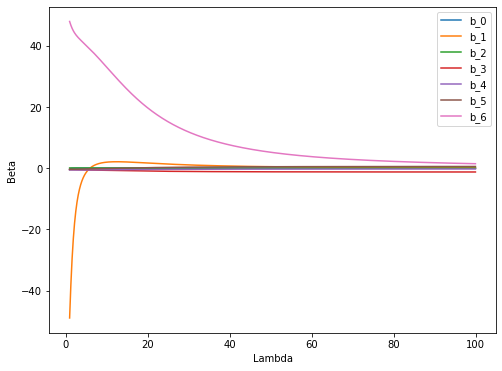

In [36]:
y = longley[['number of people employed']]
x = longley.iloc[:,1:]     

# create intercept 
itcpt = np.repeat(1,16).reshape(-1,1)

x = np.append(x, itcpt, axis = 1)
x = x[:,[6,0,1,2,3,4,5]]


X = x.T.dot(x)
Y = x.T.dot(y)

# lambda from 1 to 100
ly = np.arange(1,100,0.1) 


df = np.arange(1,8).reshape(1,-1) 

# compute and add penalty
for i in ly:
    pty = i * np.eye(7)
    X = X + pty
    c, low = cho_factor(X)
    btas = cho_solve((c,low),Y).reshape(1,-1)
    df = np.vstack((df, btas))

# remove the first r.n given
# combine to df
df = pd.DataFrame(df[1:,:]) 

plt.figure(figsize = (8,6))
plt.plot(ly, df[0], label='b_0')
plt.plot(ly, df[1], label='b_1')
plt.plot(ly, df[2], label='b_2')
plt.plot(ly, df[3], label='b_3')
plt.plot(ly, df[4], label='b_4')
plt.plot(ly, df[5], label='b_5')
plt.plot(ly, df[6], label='b_6')


plt.legend()

plt.xlabel('Lambda')
plt.ylabel('Beta')


plt.show()

5. Implement your code using parallel computing.

6. (Bonus 1 point) Find out which method is the lm() function in R is using? And which algorithm is being used? Or find out which method is the linear regression function (there are multiple, but only need to choose one) in numpy/scipy is using? And which algorithm is being used?